# Data Exploration
- No missing data in original data. Lots of missing data in IMDB set
- There are "rare" movies at the tail
    - 17% of movies have only 1 rating
    - 43% of movies have 5 or less ratings 
- Merge loses 17410 movies that aren't in the IMDB dataset


In [1]:
import pandas as pd
import os
import numpy as np
from scipy.sparse import csc_matrix
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

In [2]:
links = pd.read_csv('data/ml-25m/links.csv')
movies = pd.read_csv('data/ml-25m/movies.csv')
ratings = pd.read_csv('data/ml-25m/ratings.csv')
tags = pd.read_csv('data/ml-25m/genome-tags.csv')
relevance = pd.read_csv('data/ml-25m/genome-scores.csv')

In [3]:
# subsample ratings data: 50% of data
ratings = ratings.sample(int(len(ratings)*.5), random_state = 1)
len(ratings)

12500047

### Merge all Data (including IMDB dataset)
Searched kaggle for a larger set and did not find one that also had IMDB IDs

In [4]:
# IMDB dataset
imdb_movies = pd.read_csv('data/imdb/IMDb movies.csv')

# standardize IMDB IDs
imdb_movies['imdbId'] = imdb_movies.imdb_title_id.str.split('tt').str[1]
imdb_movies.imdbId = pd.to_numeric(imdb_movies.imdbId)

In [5]:
# merge all dataset together 
num_movies = len(movies)
# links (has imdb rating) + movies
df = pd.merge(links, movies, on = 'movieId')
# merge with imdb data
df = pd.merge(df, imdb_movies, on = 'imdbId')

# titles are different in movielens vs imdb because imdb in the original language whereas movielens all english translated
df = df.rename(columns = {'title_x':'title_eng', 'title_y':'title_orig'})

new_num_movies = len(df)

In [6]:
# limit to relevant columns
df = df[['movieId', 'title_eng', 'year', 'genre', 'genres', 'director', 'actors', 'country']]

In [7]:
# Merge rating dataset with movies
# lose some movies in merge because not in imdb movie set 
df_full = pd.merge(df, ratings, on = 'movieId')

## Missing Data Post Merge

In [176]:
# number of movies lost in merge
num_movies - new_num_movies

17410

In [177]:
new_num_movies

45013

In [178]:
df.isnull().sum()

movieId       0
title_eng     0
year          0
genre         0
genres        0
director     13
actors       20
country      10
dtype: int64

## Limit to Movies in Ratings Data

In [8]:
# limit to movies in ratings data
movie_ratings = ratings.movieId.unique()
df = df[df.movieId.isin(movie_ratings)]

# number of movies lost
new_num_movies - len(df)

6822

## Merge Genome Tagging Data

In [9]:
# merge tags and relevance scores
tags = pd.merge(tags, relevance, on = 'tagId')

# exclude movies not in main df
tags = tags[tags.movieId.isin(df.movieId.unique())]

# merge with main df to get titles
tags = pd.merge(tags, df[['movieId', 'title_eng']], on = 'movieId')

## Clean Genre Variable
- IMDB and MovieLens sometimes have a different genre list for the same movie. Take the union of both lists to get the max number of genres/information.  
- MovieLens: genres
- IMDB: genre



In [10]:
# movielens missing value
df.genres = np.where(df.genres == '(no genres listed)', np.nan, df.genres)

# convert into sets and take union 
df.genre = df.genre.str.split(', ')
df.genres = df.genres.str.split('|')

# when missing in movielens, replace to list rather than nan 
df.genres = df.genres.apply(lambda d: d if isinstance(d, list) else [])

df.genre = df.genre.apply(set)
df.genres = df.genres.apply(set)

df['genres_all'] = df.apply(lambda x: x['genre'].union(x['genres']), axis=1)
df.genres_all = df.genres_all.apply(list)

## Exploratory Visualizations
Using full dataset, not subsampled

In [87]:
def barplot(df, x, h, title, ylabel):

    fig, ax = plt.subplots(figsize = (8,6))
    sns.barplot(df[x], df[h])
    plt.xticks(rotation='vertical', size = 12)
    plt.yticks(size = 12)

    ax.set_xlabel('')
    ax.set_ylabel(ylabel, size = 12)
    ax.set_title(title, size = 14)
    
    return ax

In [12]:
def cat_list_expand(df, var):
    
    # expand lists such that one entry per row 
    expanded = df[[var, 'movieId']]
    expanded = pd.DataFrame({
        col:np.repeat(expanded[col].values, expanded[var].str.len()) for col in expanded.columns.drop(var)}
    ).assign(**{var:np.concatenate(expanded[var].values)})[expanded.columns]

    return expanded

### Frequency Distributions

__Frequency of Genres__   
Individual genres

In [88]:
# expand genre lists such that one row per entry
genres_expanded = cat_list_expand(df, 'genres_all')

# plot
genre_counts = genres_expanded.groupby('genres_all').genres_all.count().to_frame()
genre_counts.columns = ['cnt']
genre_counts = genre_counts.sort_values(['cnt'])
genre_counts['genres'] = genre_counts.index

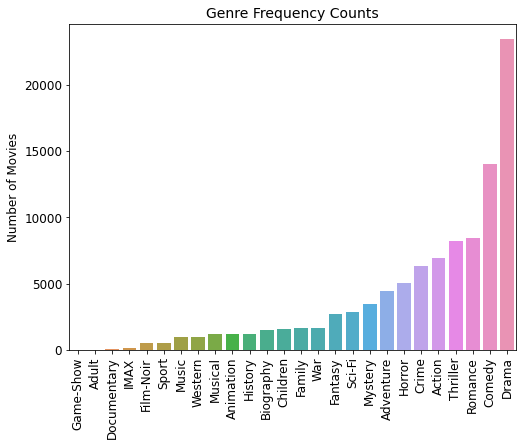

In [89]:
barplot(genre_counts, 'genres', 'cnt', 'Genre Frequency Counts', 'Number of Movies')

__Most Common Genre Combinations__

In [192]:
# convert list to tuple so hashable
df.genres_all = df.genres_all.apply(tuple)

# count by unique genre combination (verified lists internally sorted the same)
genre_combos = df.groupby('genres_all').movieId.count().to_frame()
genre_combos.columns = ['cnt']

# take top 10 most popular
genre_combos = genre_combos.sort_values('cnt').tail(10)

# clean index string 
genre_combos.index = genre_combos.index.map(str)
genre_combos['lst'] = genre_combos.index
genre_combos.lst = genre_combos.lst.str.replace('(', '').str.replace(')', '').str.replace(',', '')

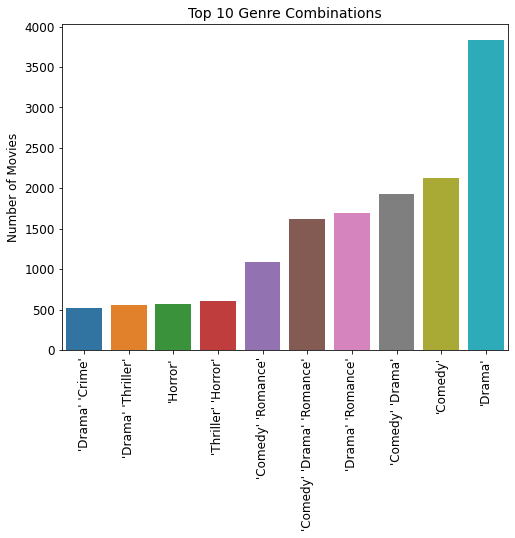

In [193]:
barplot(genre_combos, 'lst', 'cnt', 'Top 10 Genre Combinations', 'Number of Movies')

__Frequency of Movies by Year__

In [194]:
movies_yr = df.groupby('year').movieId.count().to_frame()

Text(0.5, 1.0, 'Release Year Frequency Counts')

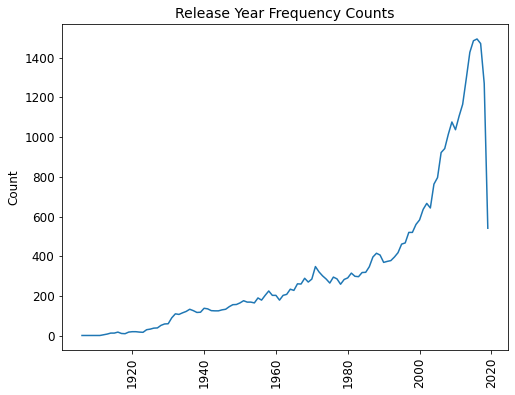

In [195]:
fig, ax = plt.subplots(figsize = (8,6))
sns.lineplot(movies_yr.index, movies_yr.movieId)
plt.xticks(rotation='vertical', size = 12)
plt.yticks(size = 12)

ax.set_xlabel('')
ax.set_ylabel('Count', size = 12)
ax.set_title('Release Year Frequency Counts', size = 14)

__Number of Movies by Filming Country__

In [196]:
# split string variable into list 
df['country_lst'] = df.country.str.split(', ')
# when missing, replace to list rather than nan 
df.country_lst = df.country_lst.apply(lambda d: d if isinstance(d, list) else [])

In [197]:
# expand actor list
country_expanded = cat_list_expand(df, 'country_lst')

# count number of movies for each country and prep for plotting
country_expanded = country_expanded.groupby('country_lst').country_lst.count().to_frame()
country_expanded.columns = ['cnt']
country_expanded = country_expanded.sort_values(['cnt'])
country_expanded['country'] = country_expanded.index

In [198]:
# percent of countries that were filming locations for only 1 movie
# do not need to include these in analysis because not useful for identifying similar movies
print(len(country_expanded[country_expanded.cnt == 1]) / len(country_expanded))

country_exclude = country_expanded[country_expanded.cnt == 1].country.unique()

0.17647058823529413


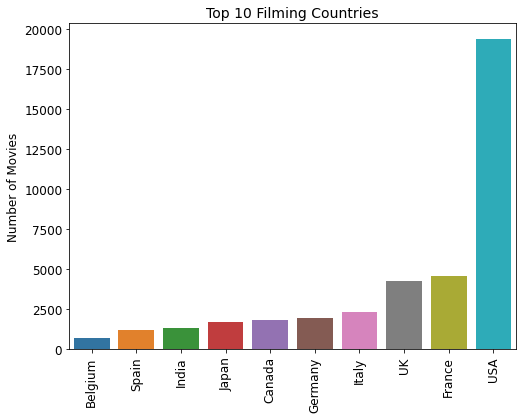

In [199]:
barplot(country_expanded.tail(10), 'country', 'cnt', 'Top 10 Filming Countries', 'Number of Movies')

__Most Common Actors__

In [18]:
# split string variable into list 
df['actor_lst'] = df.actors.str.split(', ')
# when missing, replace to list rather than nan 
df.actor_lst = df.actor_lst.apply(lambda d: d if isinstance(d, list) else [])

In [19]:
# expand actor list
actors_expanded = cat_list_expand(df, 'actor_lst')

# count number of movies for each actor and prep for plotting 
actors_expanded = actors_expanded.groupby('actor_lst').actor_lst.count().to_frame()
actors_expanded.columns = ['cnt']
actors_expanded = actors_expanded.sort_values(['cnt'])
actors_expanded['actors'] = actors_expanded.index

In [202]:
# percent of actors that are only in 1, <= 2 movies
# do not need to include these in analysis because not useful for identifying similar movies
     # even actors in only 2 movies. If watched one of the movies, could recommend the other one, but that is it. 
print(len(actors_expanded[actors_expanded.cnt == 1]) / len(actors_expanded))

actors_exclude = actors_expanded[actors_expanded.cnt == 2].actors.unique()

0.6727145435451681


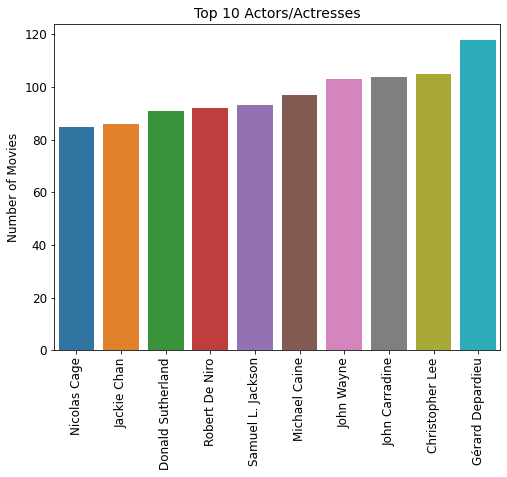

In [203]:
barplot(actors_expanded.tail(10), 'actors', 'cnt', 'Top 10 Actors/Actresses', 'Number of Movies')

__Most Common Directors__

In [20]:
# split string variable into list
df['director_lst'] = df.director.str.split(', ')
# when missing, replace to list rather than nan 
df.director_lst = df.director_lst.apply(lambda d: d if isinstance(d, list) else [])

In [21]:
# expand actor list
directors_expanded = cat_list_expand(df, 'director_lst')

# count number of movies for each actor and prep for plotting 
directors_expanded = directors_expanded.groupby('director_lst').director_lst.count().to_frame()
directors_expanded.columns = ['cnt']
directors_expanded = directors_expanded.sort_values(['cnt'])
directors_expanded['director'] = directors_expanded.index

In [206]:
# percent of directors that are only in 1, <= 2 movies
# do not need to include these in analysis because not useful for identifying similar movies
print(len(directors_expanded[directors_expanded.cnt == 1]) / len(directors_expanded))

directors_exclude = directors_expanded[directors_expanded.cnt == 1].director.unique()

0.5935825621042377


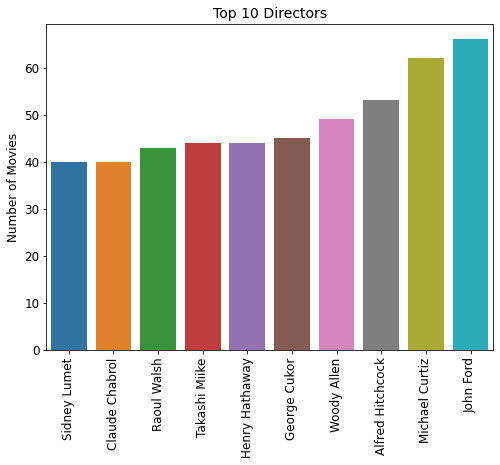

In [207]:
barplot(directors_expanded.tail(10), 'director', 'cnt', 'Top 10 Directors', 'Number of Movies')

### Genome Tags

__Distribution of Tag Relevance__    
Most tags have low relevance for most movies

Text(0.5, 1.0, 'Distribution of Tag Relevance Scores')

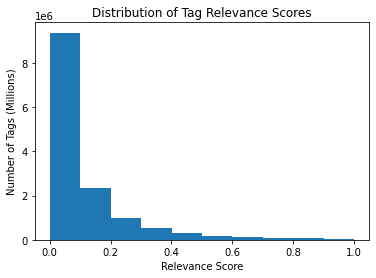

In [208]:
plt.hist(tags.relevance)
plt.xlabel('Relevance Score')
plt.ylabel('Number of Tags (Millions)')
plt.title('Distribution of Tag Relevance Scores')

__Most Common Genome Tags__

In [209]:
# limit to tags that have over 50% relevance for a movie
relevant_tags = tags[tags.relevance > 0.5]

In [210]:
tag_count = relevant_tags.groupby('tag').movieId.count().to_frame()
tag_count.columns = ['cnt']
tag_count['tag'] = tag_count.index
tag_count = tag_count.sort_values('cnt')

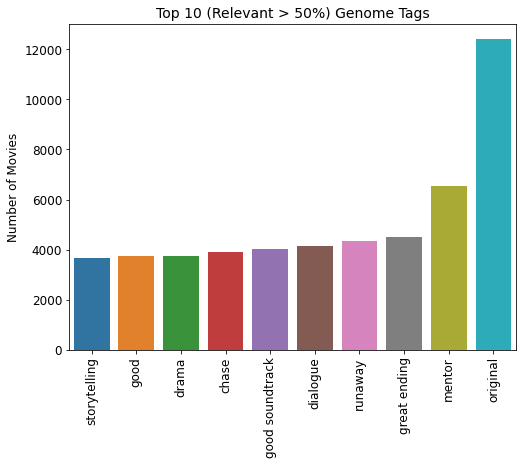

In [211]:
barplot(tag_count.tail(10), 'tag', 'cnt', 'Top 10 (Relevant > 50%) Genome Tags', 'Number of Movies')

__Number of Tags per Movie__    
When we filter, how much can we expect to return for each tag

In [212]:
tag_movies = relevant_tags.groupby('movieId').tag.count().to_frame()
tag_movies.columns = ['cnt']
tag_movies['movie'] = tag_movies.index
tag_movies = tag_movies.sort_values('cnt')

Text(0.5, 1.0, 'Distribution of Number of Tags per Movie')

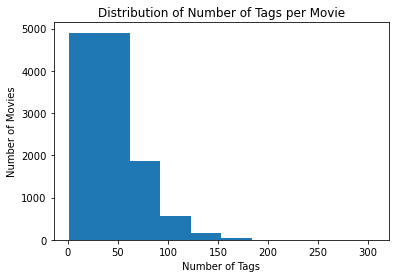

In [213]:
plt.hist(tag_movies.cnt)
plt.xlabel('Number of Tags')
plt.ylabel('Number of Movies')
plt.title('Distribution of Number of Tags per Movie')

## Ratings Data

__Frequency of Year of Review__: Do we have older reviews that should be downweighted?

In [ ]:
# convert timestamp to date variable
ratings['date'] =  ratings.timestamp.apply(lambda row: datetime.datetime.fromtimestamp(row))
ratings['year'] = ratings.date.dt.year

# count number of ratings per year
ratings_year = ratings.groupby('year').rating.count().to_frame()
ratings_year.columns = ['cnt']
ratings_year['year'] = ratings_year.index

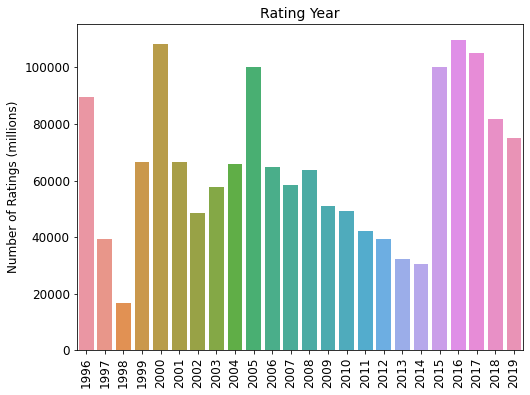

In [96]:
barplot(ratings_year, 'year', 'cnt', 'Rating Year', 'Number of Ratings (millions)')

__Distribution of Number of Ratings by Movie__: How much of a long tail do we have of less popular movies?    
Lots of movies with only a few ratings (<10)

Text(0.5, 1.0, 'Distribution of Number Ratings by Movie: Many "Unpopular" Movies')

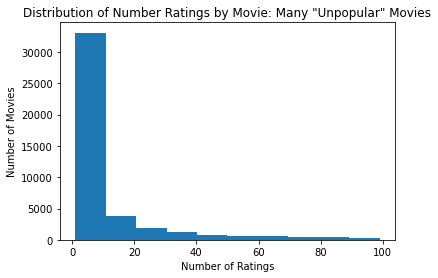

In [62]:
ratings_movie = ratings.groupby('movieId').rating.count().to_frame()
plt.hist(ratings_movie[ratings_movie.rating < 100].rating)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Number Ratings by Movie: Many "Unpopular" Movies') 

In [68]:
# percent of movies with fewer than 10 ratings: 63%
len(ratings_movie[ratings_movie.rating < 10]) / len(ratings_movie)

0.633923326937385

__Distribution of Ratings__: more positive or more negative ratings?    
Skewed towards positive ratings -- good for our purposes, don't care much about low ratings

Text(0.5, 1.0, 'Distribution of Ratings')

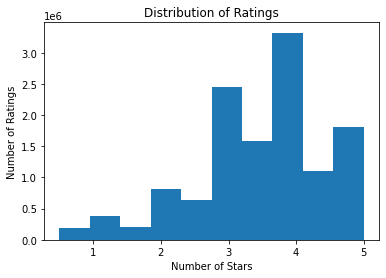

In [50]:
plt.hist(ratings.rating)
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Ratings')

## Most Highly Rated 

In [101]:
def most_highly_rated(var):
    
    ratings_gb = df_full.groupby(var).rating.mean().to_frame()
    ratings_gb.columns = ['avg']
    ratings_gb['id'] = ratings_gb.index
    ratings_gb = pd.merge(ratings_gb, df[['movieId', 'title_eng']], left_on = 'id', right_on = 'movieId')

    # many movies with average = 5, but many of these have only been rated a few times
    # merge and secondary sort by number of ratings
    num_ratings = df_full.groupby('movieId').rating.count().to_frame()
    num_ratings.columns = ['cnt']
    num_ratings['id'] = num_ratings.index

    ratings_gb = pd.merge(ratings_gb, num_ratings, on = 'id')

    # sort on rating and number of ratings
    ratings_gb = ratings_gb.sort_values(['avg',  'cnt'], ascending = True)
    
    # exclude if fewer than 100 ratings
    ratings_gb = ratings_gb[ratings_gb.cnt >= 100]
    
    return ratings_gb

__Most highly rated movies__

In [102]:
movie_ratings = most_highly_rated('movieId')

(0.0, 5.0)

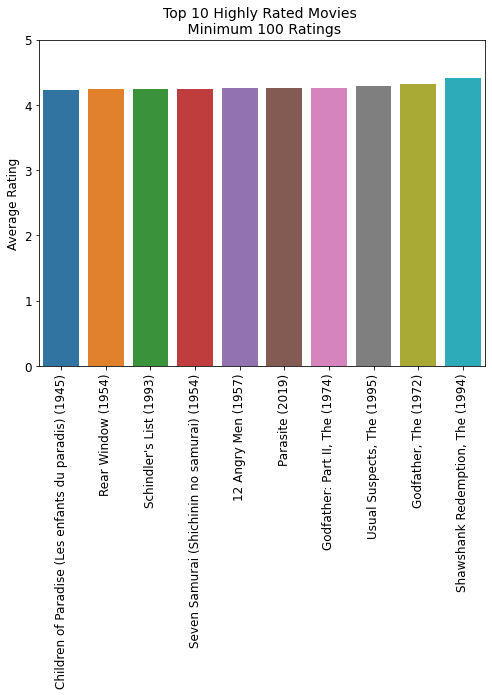

In [104]:
ax = barplot(movie_ratings.tail(10), 'title_eng', 'avg', 'Top 10 Highly Rated Movies \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated actors__    
Average scores of all movies they are in 

In [105]:
# expand
actors_expanded = cat_list_expand(df, 'actor_lst')

# merge with movie rating data: get average rating and rating count of each movie each actor has been in
# excludes movies with fewer than 100 ratings: shouldn't take average of average based on these
actors_rating = pd.merge(actors_expanded, movie_ratings, on = 'movieId')
# aggregate by actor
actors_rating = actors_rating.groupby('actor_lst').agg({'avg':'mean', 'cnt':'sum'})
actors_rating['actor'] = actors_rating.index
actors_rating = actors_rating.sort_values('avg')

# exclude if in total movies with less than 100 ratings
actors_rating = actors_rating[actors_rating.cnt >= 100]

(0.0, 5.0)

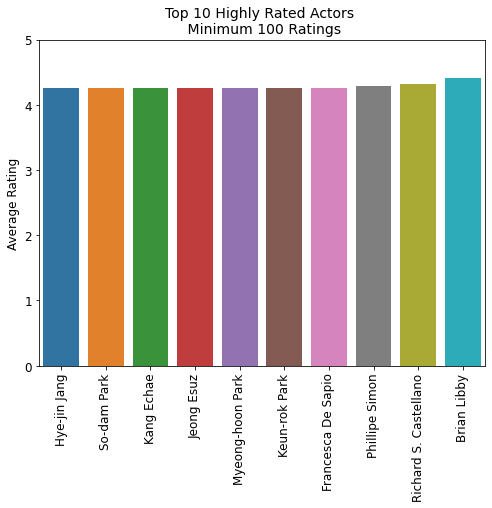

In [106]:
ax = barplot(actors_rating.tail(10), 'actor', 'avg', 'Top 10 Highly Rated Actors \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated directors__

In [107]:
# expand
directors_expanded = cat_list_expand(df, 'director_lst')

# merge with movie rating data: get average rating and rating count of each movie each actor has been in
# excludes movies with fewer than 100 ratings: shouldn't take average of average based on these
director_rating = pd.merge(directors_expanded, movie_ratings, on = 'movieId')
# aggregate by actor
director_rating = director_rating.groupby('director_lst').agg({'avg':'mean', 'cnt':'sum'})
director_rating['director'] = director_rating.index
director_rating = director_rating.sort_values('avg')

# exclude if in total movies with less than 100 ratings
director_rating = director_rating[director_rating.cnt >= 100]

(0.0, 5.0)

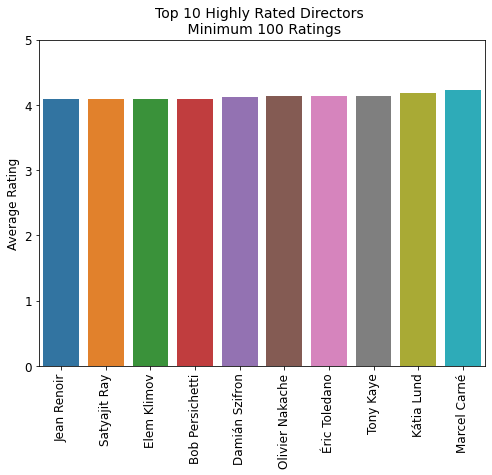

In [108]:
ax = barplot(director_rating.tail(10), 'director', 'avg',
             'Top 10 Highly Rated Directors \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated genres__

In [121]:
# expand
genres_expanded = cat_list_expand(df, 'genres_all')

# merge with movie rating data: get average rating and rating count of each movie each actor has been in
# excludes movies with fewer than 100 ratings: shouldn't take average of average based on these
genres_expanded = pd.merge(genres_expanded, movie_ratings, on = 'movieId')
# aggregate by genre
genres_expanded = genres_expanded.groupby('genres_all').agg({'avg':'mean', 'cnt':'sum'})
genres_expanded['genre'] = genres_expanded.index
genres_expanded = genres_expanded.sort_values('avg')

# exclude if in total movies with less than 100 ratings
#genres_expanded = genres_expanded[genres_expanded.cnt >= 100]

(0.0, 5.0)

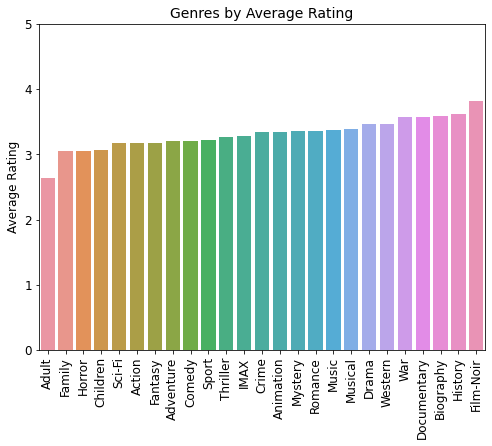

In [123]:
ax = barplot(genres_expanded, 'genre', 'avg',
             'Genres by Average Rating', 'Average Rating')
ax.set_ylim(0,5)

## Create Dummy Variables  


__Exclude Rare Actors, Directors: Not Useful for Recommendations__    
And including all results in memory errors

- Actors
- Directors
    - Exclude actors and directors that have only been in 1 movie in dataset. Not relevant for finding similar movies
    - May need to rerun this piece once subset data as there may be more in only 1 movie 

In [17]:
# exclude if only in 1 movie (in dataset)
df.actor_lst = df.actor_lst.map(set) - set(actors_exclude)
df.director_lst = df.director_lst.map(set) - set(directors_exclude)

# map back to list
df.actor_lst = df.actor_lst.map(list)
df.director_lst = df.director_lst.map(list)

AttributeError: 'DataFrame' object has no attribute 'actor_lst'

__Create Dummies__    
Taking out actors and directors with fewer than 3 movies, but still memory issues. Directors ok.     
New idea: take top actors form each movie (listed in billing order - I think?)

In [ ]:
# clear up memory 
del imdb_movies
del actors_expanded
del directors_expanded 
del movies
del links

In [29]:
#for var in ['genres_all', 'actor_lst', 'director_lst']:

for var in ['director_lst']:

    prefix = var.split('_')[0]

    # dummy variables
    dummies = pd.get_dummies(df[var].apply(pd.Series).stack(), prefix = prefix).sum(level = 0)

    # merge back in
    df = pd.merge(df, dummies, left_index = True, right_index = True)

## Create User-Ratings Utility Matrix

In [24]:
ratings = ratings.sort_values(['userId', 'movieId'])
users_c = CategoricalDtype(sorted(ratings.userId.unique()), ordered=True)
movies_c = CategoricalDtype(sorted(ratings.movieId.unique()), ordered=True)

row = ratings.userId.astype(users_c).cat.codes
col = ratings.movieId.astype(movies_c).cat.codes
utility_matrix = csc_matrix((ratings.rating, (row, col)), 
                           shape=(users_c.categories.size, movies_c.categories.size))

utility_matrix.shape # row = users, columns = movies

In [72]:
# check: look at userId = 1, what movies have non-zero values in the matrix?
print(utility_matrix[0,:].nonzero())

# find indexes of movie IDs 
movies_lst = sorted(ratings.movieId.unique())
movies_lst.index(296) # movieId 296 = index 292. First nonzero element in sparse matrix. 

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0]), array([ 292,  302,  303,  654,  878, 1061, 1147, 1186, 1205, 1217, 1227,
       1591, 1922, 1923, 1979, 2071, 2260, 2482, 2541, 2600, 2751, 3352,
       3470, 3845, 4040, 4203, 4220, 4317, 4598, 4867, 5041, 5161, 5573,
       5655, 5766, 5800, 5840, 5904, 6252, 6258, 6416, 6588, 6829, 7084,
       7109, 7193, 7198, 7202, 7236, 7240, 7476, 7547, 7548, 7549, 7550,
       7593, 7653, 7720, 7734, 7775, 7972, 8015, 8072, 8158, 8258, 9120,
       9143, 9304, 9645, 9778]))


292

In [73]:
ratings[ratings.userId == 1]

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
65,1,27193,3.0,1147879774
66,1,27266,4.5,1147879365
67,1,27721,3.0,1147869115
68,1,31956,3.5,1147877610
